# TCN Model

In [4]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, f1_score, r2_score
import math

In [6]:
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size
    def forward(self, x):
        return x[:, :, :-self.chomp_size]

class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation, padding):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding, dilation=dilation)
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1)
    def forward(self, x):
        return self.net(x)

class TCN(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=3):
        super().__init__()
        layers = []
        for i in range(len(num_channels)):
            dilation_size = 2 ** i
            in_ch = num_inputs if i == 0 else num_channels[i-1]
            out_ch = num_channels[i]
            padding = (kernel_size - 1) * dilation_size
            layers.append(TemporalBlock(in_ch, out_ch, kernel_size, dilation=dilation_size, padding=padding))
        self.network = nn.Sequential(*layers)
        self.linear = nn.Linear(num_channels[-1], 1)
    def forward(self, x):
        y = self.network(x)
        return self.linear(y[:, :, -1])

## Data Preparation and rolling evaluation

In [8]:
# Load dataset
df = pd.read_csv("RELIANCE.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df[['Date', 'Close']].dropna()
df = df.sort_values("Date")
df['LogReturn'] = np.log(df['Close'] / df['Close'].shift(1))
df['RealizedVol'] = df['LogReturn'].rolling(window=5).apply(lambda x: np.sqrt(np.mean(x**2)))
df.dropna(inplace=True)

# Normalize
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df['Close_scaled'] = scaler.fit_transform(df[['Close']])

# TCN inputs
def create_sequences(data, window):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

## Defining Rolling Window

In [10]:
window = 20
X, y = create_sequences(df['Close_scaled'].values, window)

# Convert to torch tensors
X_tensor = torch.FloatTensor(X).unsqueeze(1)  # (N, 1, T)
y_tensor = torch.FloatTensor(y)

## Model Training and Prediction

In [12]:
# Rolling evaluation
mae_list, rmse_list, acc_list, f1_list, vol_rmse_list = [], [], [], [], []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pred_dates = []
actuals = []
predictions = []

for i in range(len(X_tensor) - 30, len(X_tensor) - 1):
    model = TCN(num_inputs=1, num_channels=[16, 16])
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    X_train = X_tensor[:i].to(device)
    y_train = y_tensor[:i].to(device)

    # Train
    model.train()
    for epoch in range(50):
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output.squeeze(), y_train)
        loss.backward()
        optimizer.step()

    # Predict next value
    model.eval()
    with torch.no_grad():
        pred = model(X_tensor[i].unsqueeze(0).to(device)).item()
        actual = y_tensor[i + 1].item()
        prev = y_tensor[i].item()

    # Reverse scaling
    pred_real = scaler.inverse_transform([[pred]])[0][0]
    actual_real = scaler.inverse_transform([[actual]])[0][0]
    prev_real = scaler.inverse_transform([[prev]])[0][0]

    pred_dates.append(df['Date'].iloc[i + window + 1])
    actuals.append(actual_real)
    predictions.append(pred_real)

    # Price metrics
    mae_list.append(mean_absolute_error([actual_real], [pred_real]))
    rmse_list.append(math.sqrt(mean_squared_error([actual_real], [pred_real])))

    # Direction
    true_dir = int(actual_real > prev_real)
    pred_dir = int(pred_real > prev_real)
    acc_list.append(accuracy_score([true_dir], [pred_dir]))
    f1_list.append(f1_score([true_dir], [pred_dir], zero_division=1))

    # Volatility (naive)
    actual_vol = df['RealizedVol'].iloc[i + window + 1]
    pred_vol = df['RealizedVol'].iloc[i + window]
    if not np.isnan(actual_vol) and not np.isnan(pred_vol):
        vol_rmse_list.append(math.sqrt(mean_squared_error([actual_vol], [pred_vol])))


## Metrics

In [14]:
# Print results
print("\n TCN Rolling Evaluation Summary:\n")
print(f"Price Prediction: MAE = {np.mean(mae_list):.4f}, RMSE = {np.mean(rmse_list):.4f}")
print(f" Direction Prediction: Accuracy = {np.mean(acc_list):.4f}, F1 = {np.mean(f1_list):.4f}")
print(f" Volatility Prediction: RMSE = {np.mean(vol_rmse_list):.6f}")


 TCN Rolling Evaluation Summary:

Price Prediction: MAE = 59.7079, RMSE = 59.7079
 Direction Prediction: Accuracy = 0.5517, F1 = 0.5517
 Volatility Prediction: RMSE = 0.002093


## Visualisation

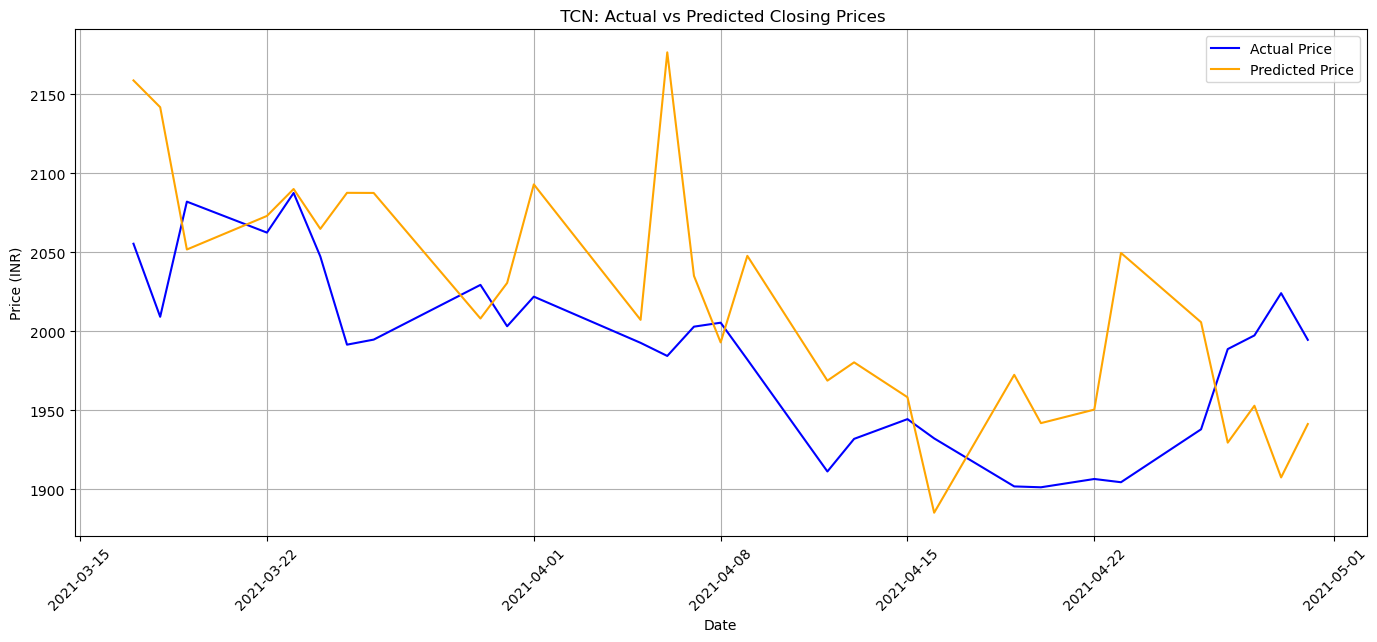

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(pred_dates, actuals, label='Actual Price', color='blue')
plt.plot(pred_dates, predictions, label='Predicted Price', color='orange')
plt.title(" TCN: Actual vs Predicted Closing Prices")
plt.xlabel("Date")
plt.ylabel("Price (INR)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()